In [1]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from lmfit import minimize, Parameters, Parameter, report_fit
from numpy import asarray
from numpy import savetxt
import os
import time
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
start = time.time() #Saves the begining time of the process

from Funciones import EstimacionVariables, DifFinitas2

In [2]:
#Variables conocidas del modelo SIR

gamma = 1./21.
fechas = pd.read_csv('Fechas/' + 'Fechas.csv')
#####################################################

depas = pd.read_csv('DEPARTAMENTOS/Departamentos.csv')
NOMBREDEPTO =  depas["Departamentos"]
#####################################################

POSITIVOSDEPTO = [] 
for n in range(len(NOMBREDEPTO)):
    rep_diarios = pd.read_csv('dA/' + NOMBREDEPTO[n] + '_ReporteDiario.csv')
    c = rep_diarios["Reporte_Diario"].values.tolist()
    POSITIVOSDEPTO.append(c)
#####################################################    

acumuladosReportados = [] 
for n in range(len(NOMBREDEPTO)):
    acumulados = pd.read_csv('ACUMULADOS/' + NOMBREDEPTO[n] + '_Acumulados_Reportados.csv')
    c = acumulados["Acumulados_Reportados"].values.tolist()
    acumuladosReportados.append(c)
    
#####################################################    

Poblacion = pd.read_csv('POBLACION/' + 'Poblacion.csv')["Poblacion"].values.tolist()

In [3]:
A, dA, S, I,R, Beta, Rt, R0 = EstimacionVariables(acumuladosReportados, POSITIVOSDEPTO, Poblacion, gamma)

In [4]:
def adfuller_test(serie):
    result=adfuller(serie)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
    return result

In [5]:
adfuller_test(Beta[0][:587])

ADF Test Statistic : -2.2323215982327107
p-value : 0.19472436633031864
#Lags Used : 15
Number of Observations : 571
weak evidence against null hypothesis,indicating it is non-stationary 


(-2.2323215982327107,
 0.19472436633031864,
 15,
 571,
 {'1%': -3.4418542752662518,
  '5%': -2.8666150225357914,
  '10%': -2.569472836146374},
 -5893.221470735355)

In [6]:
#si quiere de grado 2, aplique dos veces Diferencias con grado=1
#para quitar tendencia y periodicidad
def Diferencias(serie): #grado 1 implicito
    #suponga grado = 1
    #serie = [1,2,3,4,5]
    s1 = np.array(serie[:len(serie)-1]) #[1,2,3,4]
    s2 = np.array(serie[1:])#[2,3,4,5]
    serie_nueva = (s2-s1).tolist()
    return serie_nueva

In [7]:
#serie_nueva = Diferencias(Beta[0][:583])
serie_nueva = Diferencias(Beta[0][:595])


In [8]:
adfuller_test(serie_nueva)

ADF Test Statistic : -7.823088129097366
p-value : 6.590159748350945e-12
#Lags Used : 14
Number of Observations : 579
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


(-7.823088129097366,
 6.590159748350945e-12,
 14,
 579,
 {'1%': -3.441694608475642,
  '5%': -2.866544718556839,
  '10%': -2.5694353738653684},
 -5905.326046445853)

In [9]:
#Es un proceso estacionario!
inicio = 586
fin = 690
t= []
for i in range(inicio, fin+1):
    t.append(i)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


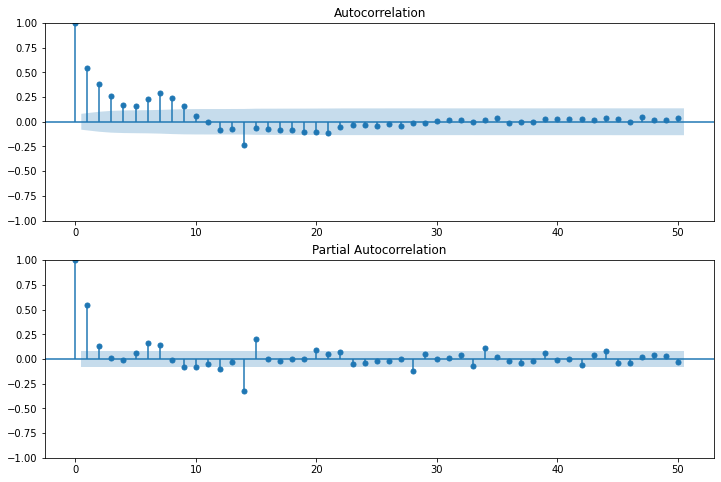

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(serie_nueva, lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(serie_nueva, lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_SerieNueva_GT_ola1.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


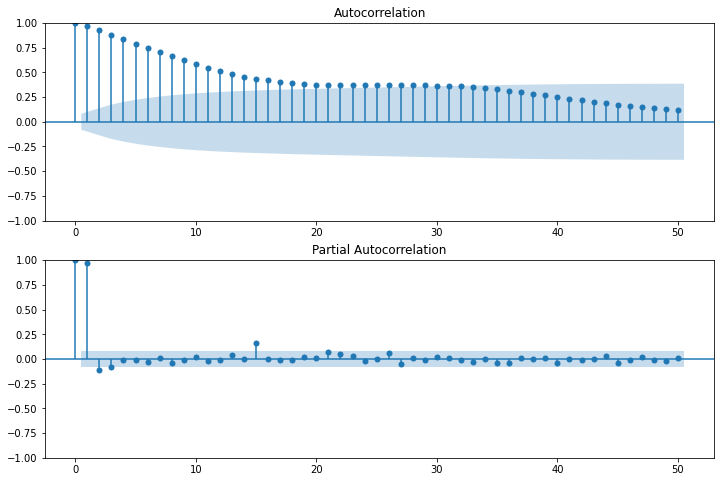

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Beta[0][:583], lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Beta[0][:583], lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_Beta_GT_ola1.pdf', bbox_inches = 'tight')


In [12]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of difference.
#q: The size of the moving average window, also called the order of moving average.

In [13]:
def ECM(x,y):
    #y es lo observado
    X = np.array(x)
    Y = np.array(y)
    Z = (X-Y)**2
    return Z.mean()

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


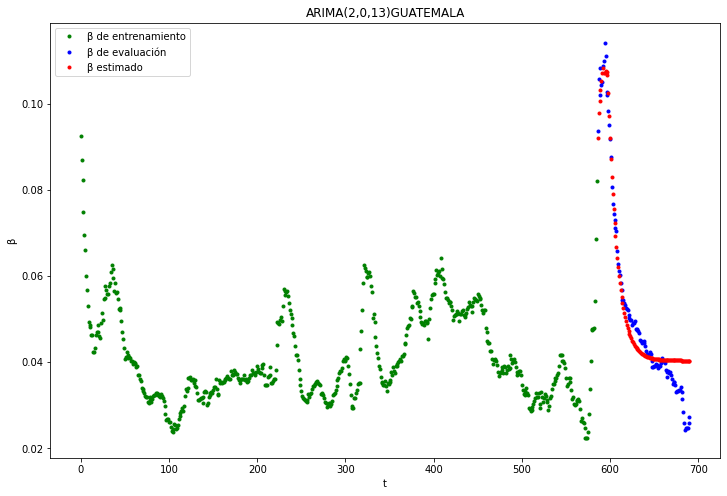

In [14]:
p=2
d=0
q = 13
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_e.pdf', bbox_inches = 'tight')


In [15]:
forecast[len(forecast)-4:len(forecast)-1], max(forecast)

(array([0.04038622, 0.04038512, 0.04038412]), 0.10826173910215146)

In [16]:
#calcular el ECM para solo unos dias, ya que en la practica no conocemas toda la evolución de la curva
p=2
d=0
Q=[]
error = []
print("q", "ECM")
for q in range(0,20):
    model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ecm = ECM(forecast[:10], Beta[0][inicio:inicio+10])
    Q.append(q)
    error.append(ecm)
    print(q, ecm)
    


q ECM
0 0.0004361245229771339
1 0.0001364488888889436
2 8.783268944277377e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


3 0.004115511367087374
4 3.118730615941726e-05
5 3.0876367851669685e-05
6 3.891769064425937e-05
7 2.6638843508278594e-05
8 0.00022681772022768216
9 0.00023236115428509996
10 0.00016336857493756283
11 0.00014806584871254264
12 0.00024107625182560695


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13 2.0100461727389345e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14 0.00017179540698720677
15 0.000540705647451247
16 0.0001137519115167113
17 0.00013426097090608183


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18 0.00011497037733623884


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19 0.00012260506910744497


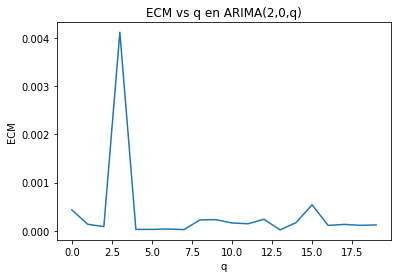

In [17]:
plt.plot(Q, error)
plt.xlabel('q')
plt.ylabel('ECM')
plt.title("ECM vs q en ARIMA(2,0,q)")
plt.savefig('Predicciones/'+'ECM.pdf', bbox_inches = 'tight')

plt.show()

In [18]:
forecast[len(forecast)-4:len(forecast)-1], max(forecast)

(array([0.04090019, 0.04090015, 0.04090011]), 0.10127691123462997)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


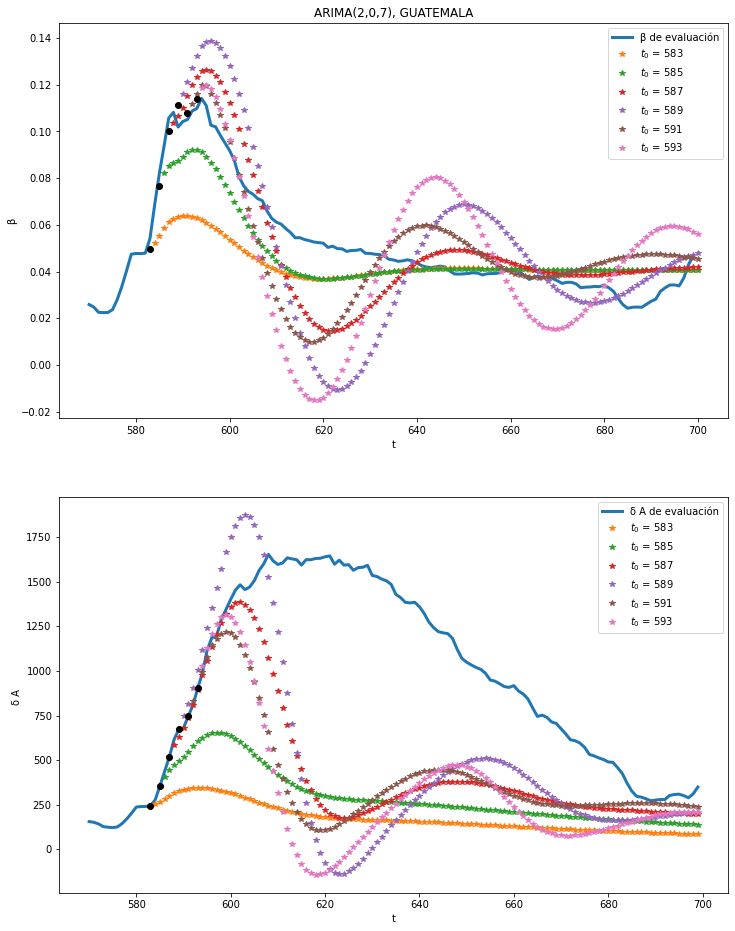

In [19]:
p=2
d=0
q=7
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(583, 595,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,7)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])



In [20]:
def PorcentajeError(p, serie):
    serie = np.array(serie)
    SUP = serie + serie*p/100
    INF = serie - serie*p/100
    sup = SUP.tolist()
    inf = INF.tolist()
    return sup, inf

In [21]:
a=[1,2,3,4]
b, c= PorcentajeError(10,a)
b, c
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

([1.1, 2.2, 3.3, 4.4], [0.9, 1.8, 2.7, 3.6])

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmode

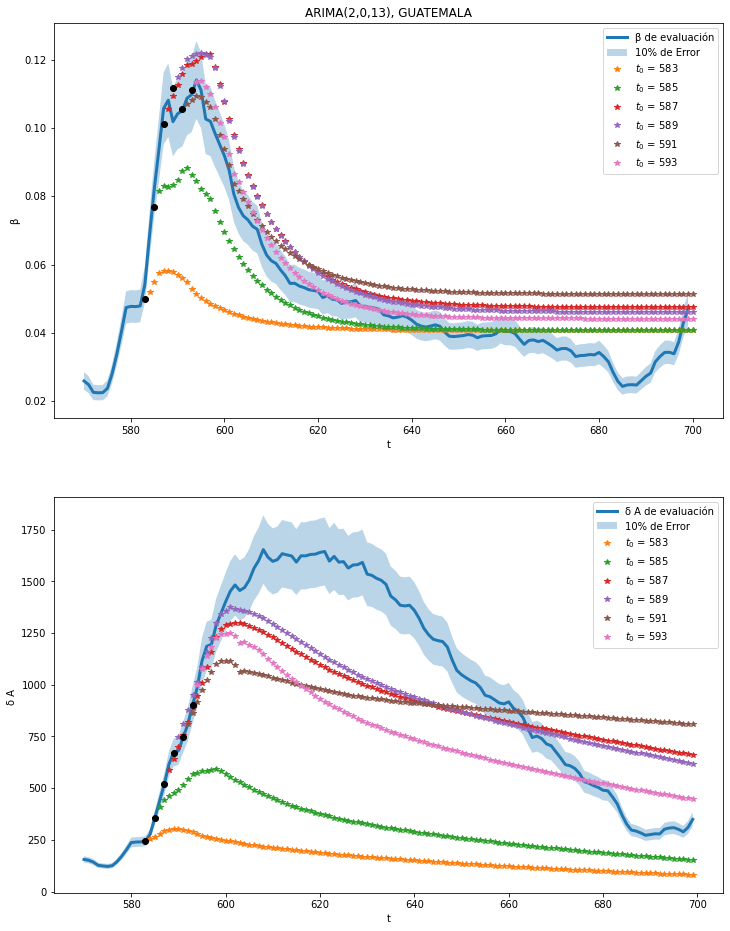

In [22]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)
    
Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1]) 


fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')

ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(583, 595,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

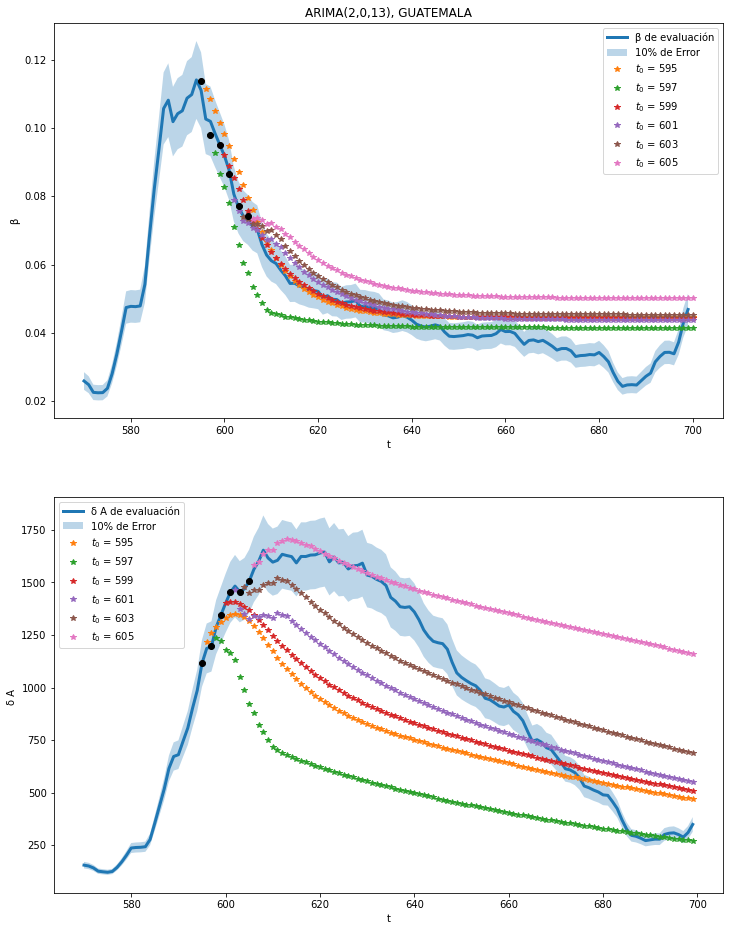

In [23]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)


Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1])     
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(595,606,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


In [64]:
fechas["Fechas"][570]

'2021-12-07'

In [65]:
len(POSITIVOSDEPTO[0])

910

In [66]:
910-570


340

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/m

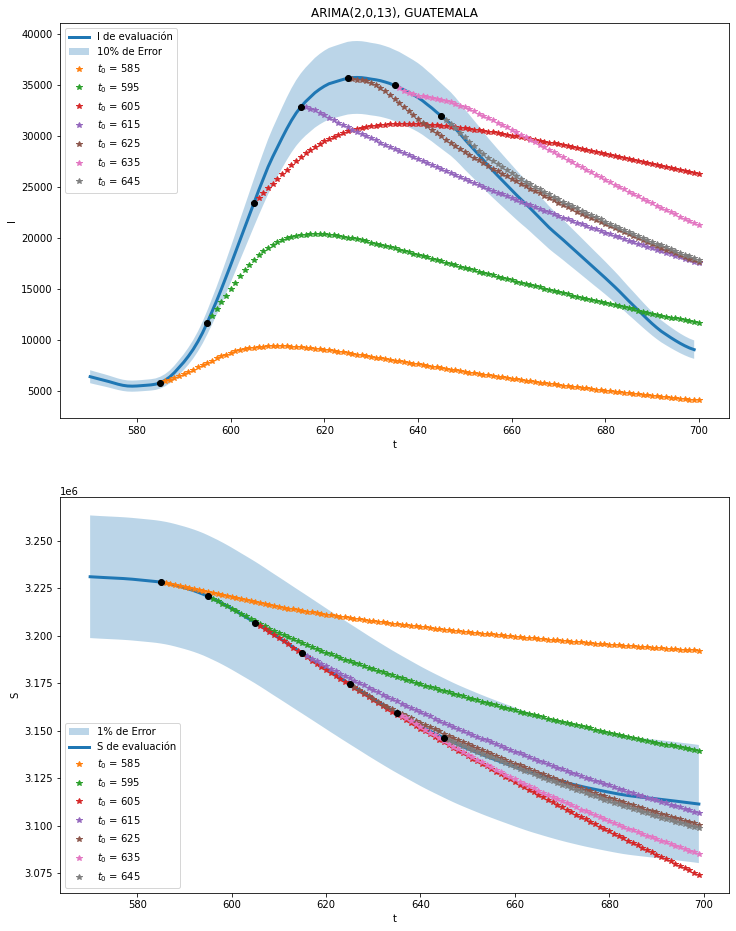

In [24]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)



I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])     
        
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')

ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(585,646,10):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])
#son confiables dentro del 1% al menos durante 1 mes

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


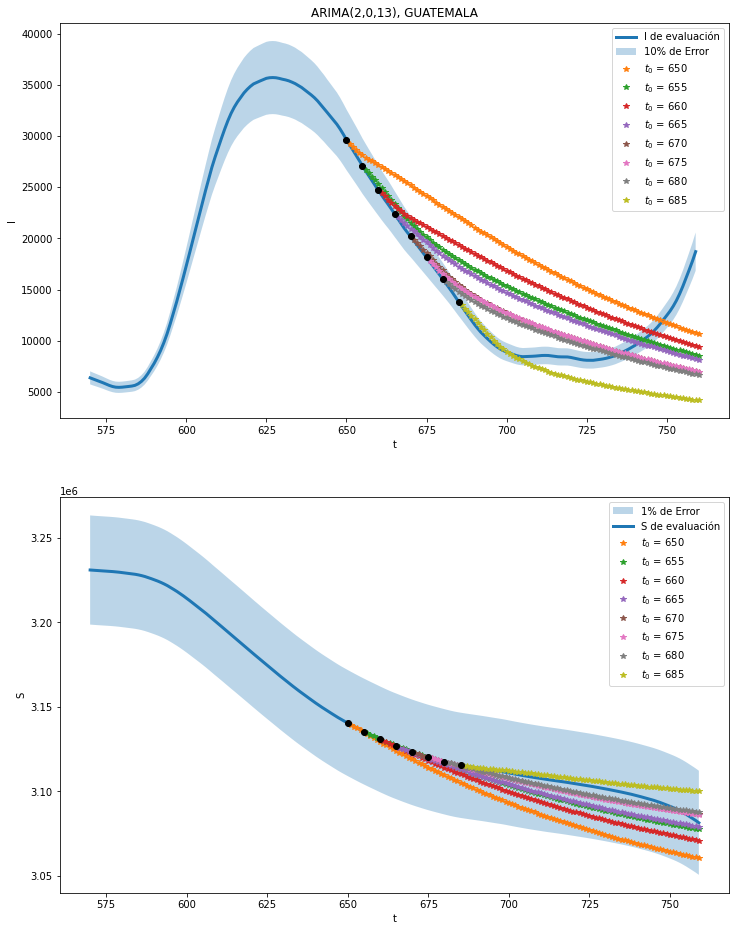

In [25]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 160
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)
    
    


I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])    

fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')

ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(650,686, 5):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


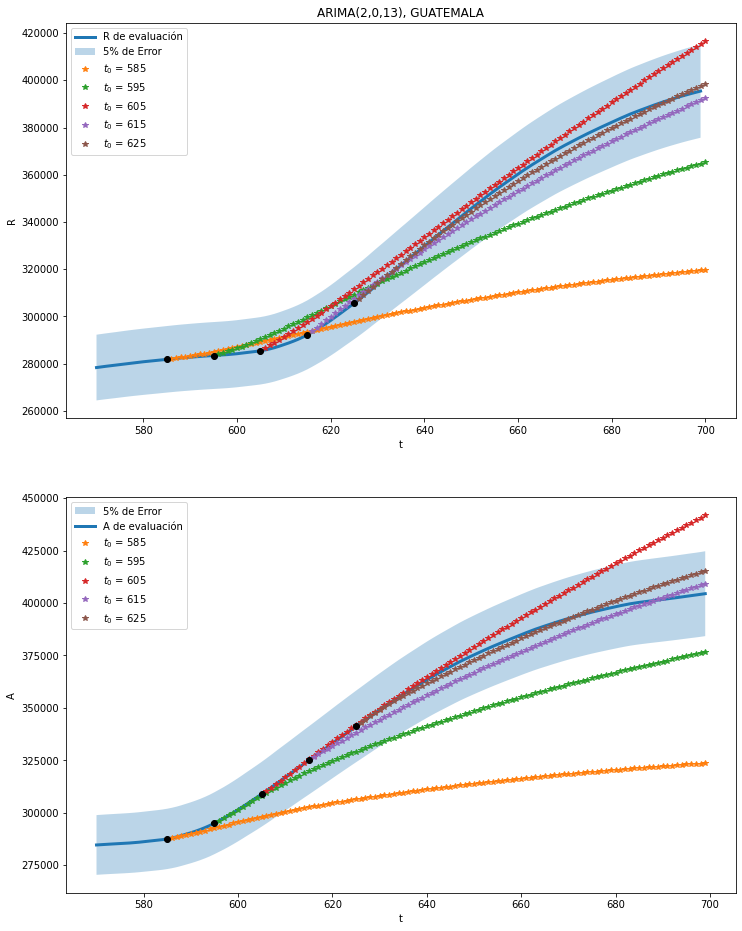

In [26]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

    


R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')

ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(585,626,10):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


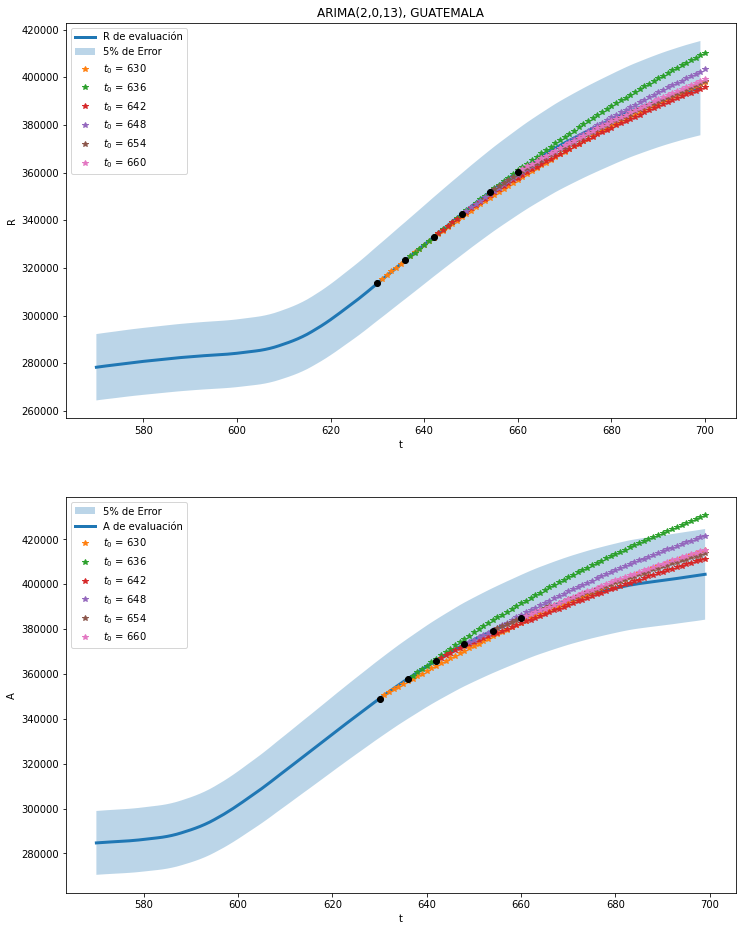

In [27]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')

ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(630,661,6):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


In [28]:
model=ARIMA(Beta[0][:640],order=(2,0,13)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  640
Model:                ARIMA(2, 0, 13)   Log Likelihood                3258.131
Date:                Sat, 01 Apr 2023   AIC                          -6482.262
Time:                        16:13:46   BIC                          -6406.417
Sample:                             0   HQIC                         -6452.823
                                - 640                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0433      0.004     11.478      0.000       0.036       0.051
ar.L1          0.9553      0.162      5.911      0.000       0.639       1.272
ar.L2         -0.0383      0.155     -0.247      0.805      -0.342       0.265
ma.L1          0.4421      0.160      2.760      0.006       0.128       0.756
ma.L2          0.2792      0.075      3.735      0.000       0.133       0.426
ma.L3          0.2546      0.049      5.205      0.000       0.159       0.350
ma.L4          0.1785      0.041      4.379      0.000       0.099       0.258
ma.L5          0.1047      0.038      2.790      0.005       0.031       0.178
ma.L6          0.2738      0.029      9.323      0.000       0.216       0.331
ma.L7          0.5605      0.035     15.792      0.000       0.491       0.630
ma.L8          0.4943      0.090      5.481      0.000       0.318       0.671
ma.L9          0.3617      0.079      4.573      0.000       0.207       0.517
ma.L10         0.3206      0.063      5.098      0.000       0.197       0.444
ma.L11         0.2160      0.052      4.187      0.000       0.115       0.317
ma.L12         0.0964      0.047      2.061      0.039       0.005       0.188
ma.L13         0.2445      0.042      5.882      0.000       0.163       0.326
sigma2      2.174e-06   8.63e-08     25.203      0.000    2.01e-06    2.34e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               704.28
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
def AR(phi1, phi2, b1, b0):
    b = phi1*b0 + phi2*b1
    return b

In [61]:
t0 =760
DeltaT = 100 
Predicciones = []
phi1 = 0.9553
phi2 = -0.0383
b0 = Beta[0][t0]
b1 = Beta[0][t0+1]
Predicciones.append(b0)
Predicciones.append(b1)

for i in range(2,DeltaT):
    b_i = AR(phi1, phi2, Predicciones[i-1], Predicciones[i-2])
    Predicciones.append(b_i)



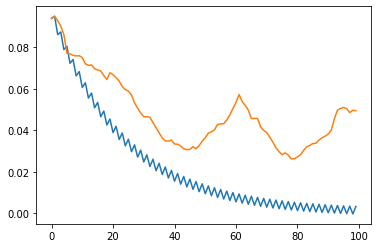

In [62]:
plt.plot(Predicciones)
plt.plot(Beta[0][t0:t0+DeltaT])